# Preliminary Phase

In this phase, we analyze the shape of the data set to understand if some data preparation processis needed.

Importing required libraries and reading the data from file.

In [1]:
import psycopg2
from config import config
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

Understanding the format of data.

In [3]:
conn = None
cur = None
df = None
try:
    # read database configuration
    params = config()
    # connect to the PostgreSQL database
    conn = psycopg2.connect(**params)
    conn.autocommit = True
    # create a new cursor
    cur = conn.cursor()
    cur.execute('SELECT version()')
    db_version = cur.fetchone()
    # print(db_version)
    df = pd.read_sql_query("SELECT rssi, unix_time FROM measurement \
            WHERE anchor_id='6C1DEBA097FA' AND \
            unix_time BETWEEN 1658824770000 AND 1658824790000;",con=conn)
    print(df)
    #os.system('pause')
    cur.close()
    if conn is not None:
        conn.close()
    
    # execute the INSERT statement

except (Exception, psycopg2.DatabaseError) as error:
    print(error)

     rssi      unix_time
0     -63  1658824770015
1     -63  1658824770036
2     -60  1658824770065
3     -63  1658824770088
4     -60  1658824770117
..    ...            ...
696   -61  1658824789857
697   -63  1658824789903
698   -58  1658824789930
699   -61  1658824789975
700   -61  1658824790000

[701 rows x 2 columns]


c:\Users\Jyun-wei\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df

,rssi,unix_time
0,-63,1658824770015
1,-63,1658824770036
2,-60,1658824770065
3,-63,1658824770088
4,-60,1658824770117
...,...,...
696,-61,1658824789857
697,-63,1658824789903
698,-58,1658824789930
699,-61,1658824789975


In [5]:
df.isna().any()

rssi         False
unix_time    False
dtype: bool

The data set has 5 column, 13.584 rows and does not contains null values.

## Data Preparation

### Timestamp

The timestamp needs to be transformed from milliseconds form to a standard format that can be used as the index. Specifically, we apply the structure based on hours, minutes, seconds, and milliseconds (hh:mm:ss.ss).

In [9]:
df['Time'] = pd.to_datetime(df['unix_time'], unit='ms').dt.strftime('%H:%M:%S.%f')

### Data cleaning

We remove the columns that are not required for our scope. Specifically, the name of the beacon, the location status, and the timestamp in milliseconds

In [14]:
df = df.drop(columns=['unix_time'])
df

,rssi,Time
0,-63,08:39:30.015000
1,-63,08:39:30.036000
2,-60,08:39:30.065000
3,-63,08:39:30.088000
4,-60,08:39:30.117000
...,...,...
696,-61,08:39:49.857000
697,-63,08:39:49.903000
698,-58,08:39:49.930000
699,-61,08:39:49.975000


In [15]:
#df['Time']
df.describe()

,rssi
count,701.000000
mean,-62.099857
std,2.568771
min,-74.000000
25%,-64.000000
50%,-62.000000
75%,-61.000000
max,-56.000000


Exploring the data set, we notice that the two columns referring to the RSSI registered from each smartphone seem to have the same values. We perform so further investigation to check that.

The investigation confirms that there are no differences between the values registered by the two smartphones. Therefore, we can drop one column and reshape the data set to enhance readability
and usability.

In [8]:
df = df.drop(columns=['rssiTwo', 'Diff'])
df.rename(columns={'rssiOne':'rssi'}, inplace=True)
df

,rssi,Time
0,-90,15:24:55.147000
1,-93,15:24:56.681000
2,-88,15:24:55.114000
3,-82,15:24:57.508000
4,-94,15:24:56.906000
...,...,...
13579,-93,15:44:53.080000
13580,-80,15:44:54.572000
13581,-89,15:44:54.032000
13582,-78,15:44:54.210000


## Plotting

We create some basic plots to further understand the data set.

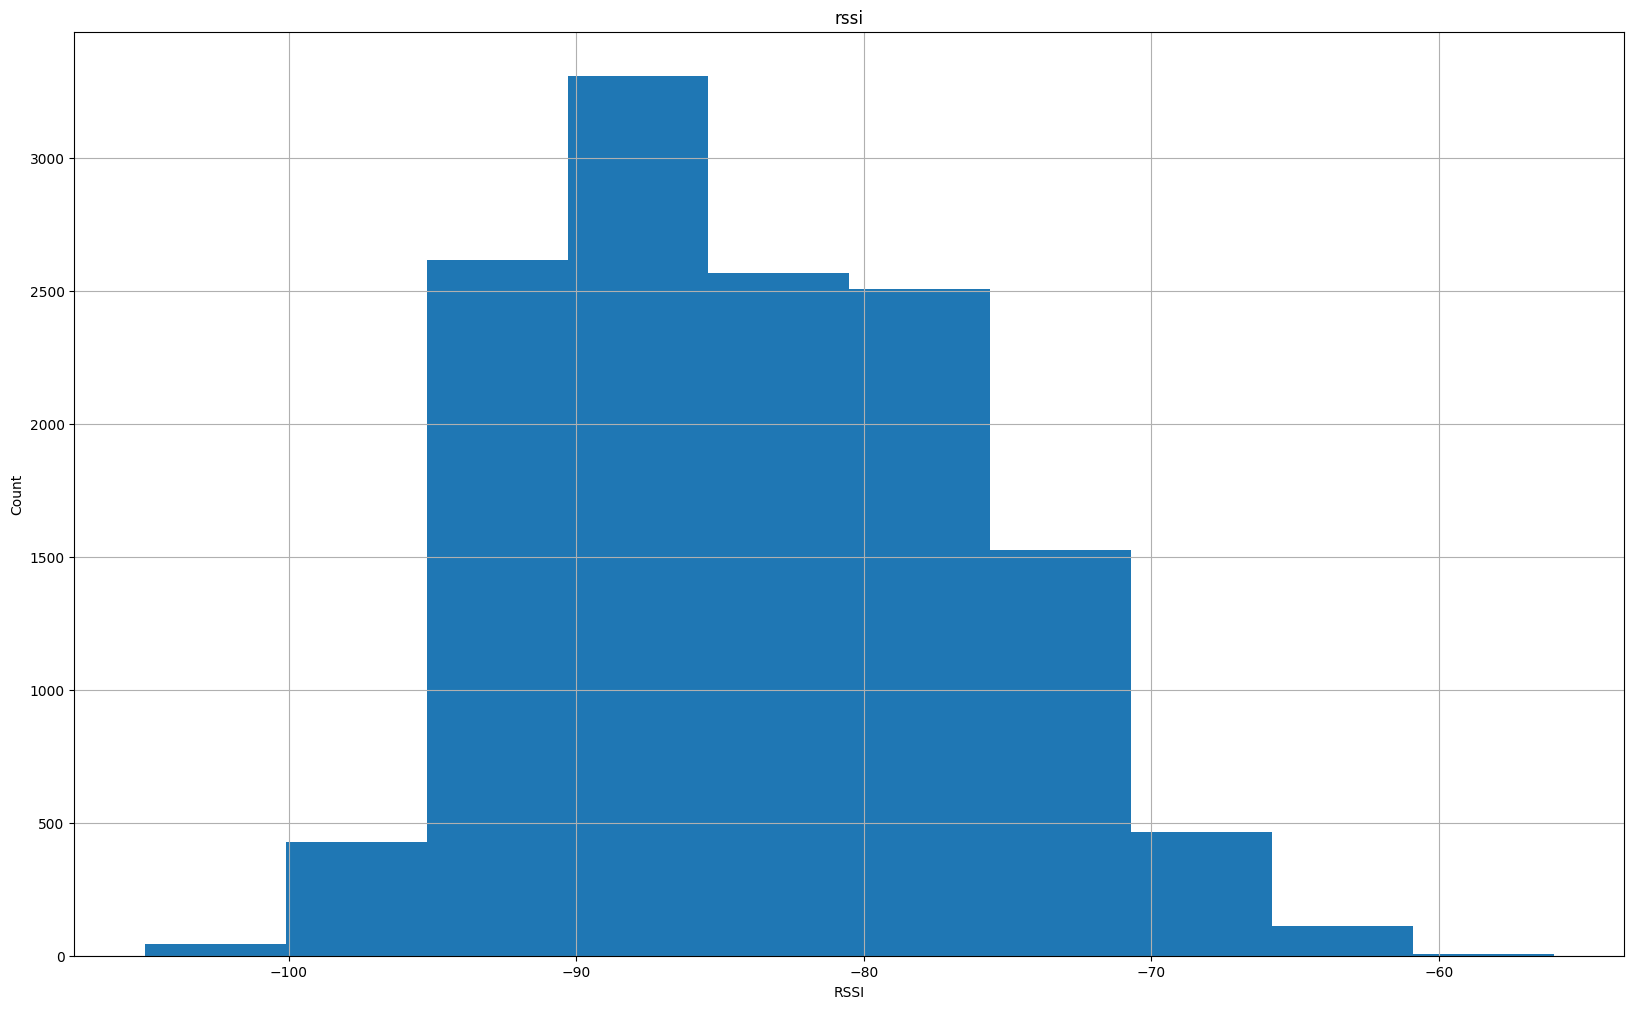

In [9]:
histCount = df.hist(column='rssi', figsize=(20, 12))
for ax in histCount.flatten():
    ax.set_xlabel('RSSI')
    ax.set_ylabel('Count')

In [10]:
df.describe()

,rssi
count,13584.000000
mean,-83.904299
std,7.609678
min,-105.000000
25%,-90.000000
50%,-85.000000
75%,-78.000000
max,-56.000000


The table and the figure show that most of the signals received are on the lower end of the spectrum, i.e., the beacon gets the majority of signals with low power intensity. The max signal strength observed is −55 dBm (decibel milliwatt), which is considered a high enough value for most real work applications. Moreover, the third percentile has a value of −78 dBm reporting an acceptable coverage.

We turn the time column into a timestamp manageble from the library in use to improve readibility.

<AxesSubplot:xlabel='Time', ylabel='RSSI'>

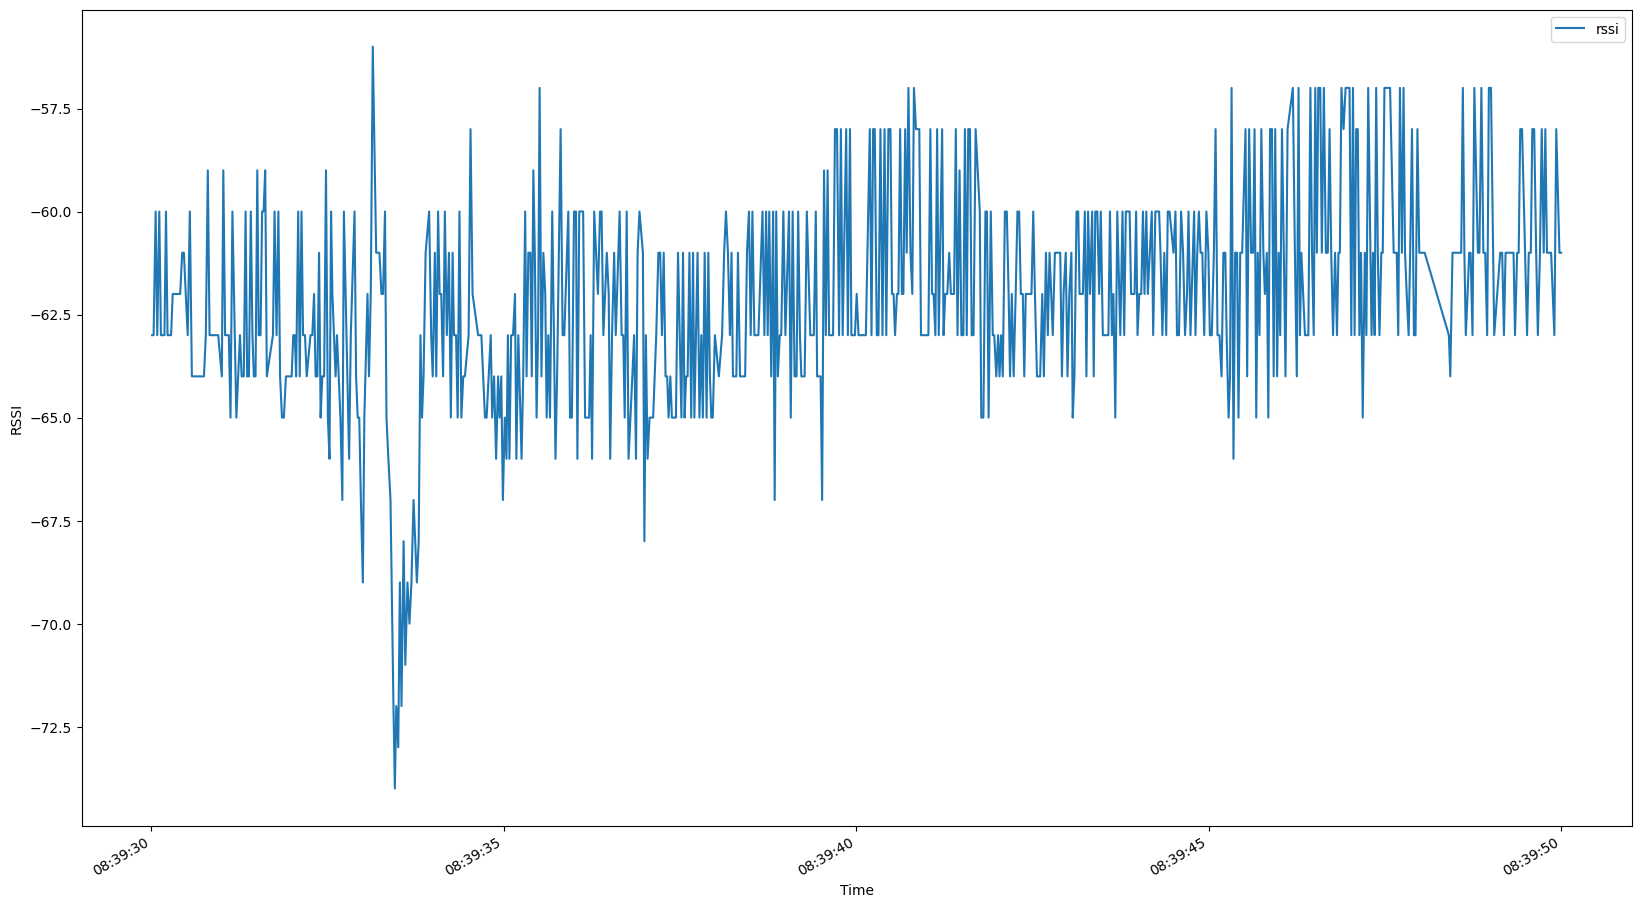

In [16]:
df['Time'] = df['Time'].apply(pd.Timestamp)
df.plot(x='Time',xlabel='Time', y='rssi', ylabel='RSSI', figsize=(20, 12))

The plot shows a high fluctuation in the signal revealing the presence of a lot of noise, as expected in an indoor environment. Therefore we need to reduce the interference using techniques
to smooth the signal. Different possible methods can be used, and the optimal solution highly depends on the specific context and the degree of noise present.

Saving the cleaned dataframe into a *.csv* file.

In [17]:
df.to_csv('../dataset/clean_data_1.csv', index=False)